In [1]:
from google.colab import drive
import zipfile
import os

# Монтируем Google Drive
drive.mount('/content/drive')

# Путь к архиву на Google Drive
zip_path = '/content/drive/MyDrive/Colab Notebooks/CV/dataset.zip'

# Путь к распакованной папке
extract_folder = '/content/drive/MyDrive/Colab Notebooks/CV/dataset/'

# Распаковываем архив
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("Архив успешно распакован.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Архив успешно распакован.


In [2]:
import os

image_folder = '/content/drive/MyDrive/Colab Notebooks/CV/dataset/dataset'  # Путь к распакованной папке
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]  # Все изображения в формате PNG

print(f"Найдено {len(image_files)} изображений.")


Найдено 9605 изображений.


In [3]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm  # Импортируем tqdm для отображения прогресса

# Загрузим предобученную модель ResNet50
resnet = models.resnet50(pretrained=True)
resnet.eval()  # Устанавливаем модель в режим оценки (не обучения)

# Преобразования для входных изображений
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Функция для извлечения признаков из изображения
def extract_features(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Добавляем batch dimension
    with torch.no_grad():
        features = resnet(image)
    return features.numpy().flatten()  # Преобразуем признаки в одномерный массив

# Загружаем все изображения и извлекаем их признаки
features_dict = {}

# Используем tqdm для отображения прогресса
for image_file in tqdm(image_files, desc="Извлечение признаков"):
    image_path = os.path.join(image_folder, image_file)
    features = extract_features(image_path)
    if features is not None:
        features_dict[image_file] = features

# Преобразуем все признаки в массив для расчета сходства
if features_dict:
    all_features = np.array(list(features_dict.values()))
    print(f"Размер массива признаков: {all_features.shape}")
else:
    print("Ошибка: не удалось извлечь признаки из изображений.")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Извлечение признаков:  11%|█▏        | 1088/9605 [06:44<52:43,  2.69it/s]


KeyboardInterrupt: 

In [8]:
all_features

array([[-0.19240989,  2.4627464 , -0.2917601 , ..., -0.24723315,
         9.288307  ,  1.664317  ],
       [-1.645961  ,  0.39755112, -1.6511954 , ...,  0.81482196,
         2.316716  ,  1.452503  ],
       [-2.406583  ,  1.4959605 , -0.8055656 , ..., -2.3946555 ,
        -0.5150236 ,  2.1171143 ],
       ...,
       [-2.349458  ,  0.8796098 , -0.35777467, ..., -1.1516715 ,
         0.22556923,  0.50981396],
       [-3.1805103 , -3.0297177 , -1.9239774 , ..., -3.7181659 ,
         0.07896385, -1.3155854 ],
       [-3.951184  , -2.16711   , -3.7005005 , ..., -2.2546902 ,
         0.51808965, -0.43882948]], dtype=float32)

In [10]:
# Рассчитываем сходство между изображениями
similarity_matrix = cosine_similarity(all_features)

# Функция для получения 6 наиболее похожих изображений
def get_similar_images(image_file, top_n=6):
    index = image_files.index(image_file)
    similarity_scores = similarity_matrix[index]
    similar_indices = similarity_scores.argsort()[-top_n-1:-1][::-1]  # Индексы 6 наиболее похожих изображений
    similar_images = [image_files[i] for i in similar_indices]
    return similar_images

# Пример для одного изображения
query_image = '3419.png'  # Замените на имя вашего изображения
similar_images = get_similar_images(query_image)

print(f"Для {query_image} похожие изображения: {similar_images}")


Для 3419.png похожие изображения: ['2535.png', '0194.png', '2086.png', '4511.png', '5961.png', '7607.png']


In [9]:
image_files

['3419.png',
 '2086.png',
 '2535.png',
 '4511.png',
 '0194.png',
 '7607.png',
 '5376.png',
 '5961.png',
 '3800.png',
 '6105.png']

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

# Функция для расчета косинусного сходства
def get_similar_images(query_image, all_features, top_k=6):
    similarities = cosine_similarity(query_image.reshape(1, -1), all_features)
    similar_indices = similarities.argsort()[0][::-1]  # Индексы самых похожих изображений (по убыванию)

    similar_images = [list(features_dict.keys())[i] for i in similar_indices[1:top_k+1]]  # Получаем имена файлов
    return similar_images

# Подготовка рекомендаций для всех изображений
recommendations = {}
for image_file, features in features_dict.items():
    similar_images = get_similar_images(features, all_features, top_k=6)
    recommendations[image_file] = ' '.join(similar_images)

# Создаем DataFrame для сохранения результатов
import pandas as pd

recommendations_df = pd.DataFrame(list(recommendations.items()), columns=['filename', 'ranking'])

# Сохраняем результат в CSV файл
recommendations_df.to_csv('/content/drive/MyDrive/Colab Notebooks/CV/recommendations.csv', index=False)

print("Рекомендации сохранены в файл.")


Рекомендации сохранены в файл.


In [13]:
display(recommendations_df)

filename                                            ranking
0  3419.png  2535.png 0194.png 2086.png 4511.png 5961.png 7...
1  2086.png  0194.png 3419.png 4511.png 5961.png 3800.png 6...
2  2535.png  7607.png 5376.png 3419.png 6105.png 5961.png 4...
3  4511.png  5961.png 0194.png 3419.png 2086.png 5376.png 2...
4  0194.png  2086.png 3419.png 4511.png 7607.png 5961.png 2...
5  7607.png  2535.png 6105.png 5376.png 3800.png 5961.png 0...
6  5376.png  2535.png 6105.png 7607.png 5961.png 3800.png 4...
7  5961.png  4511.png 2535.png 5376.png 6105.png 3419.png 7...
8  3800.png  6105.png 7607.png 5376.png 5961.png 2086.png 0...
9  6105.png  7607.png 5376.png 2535.png 3800.png 5961.png 3...

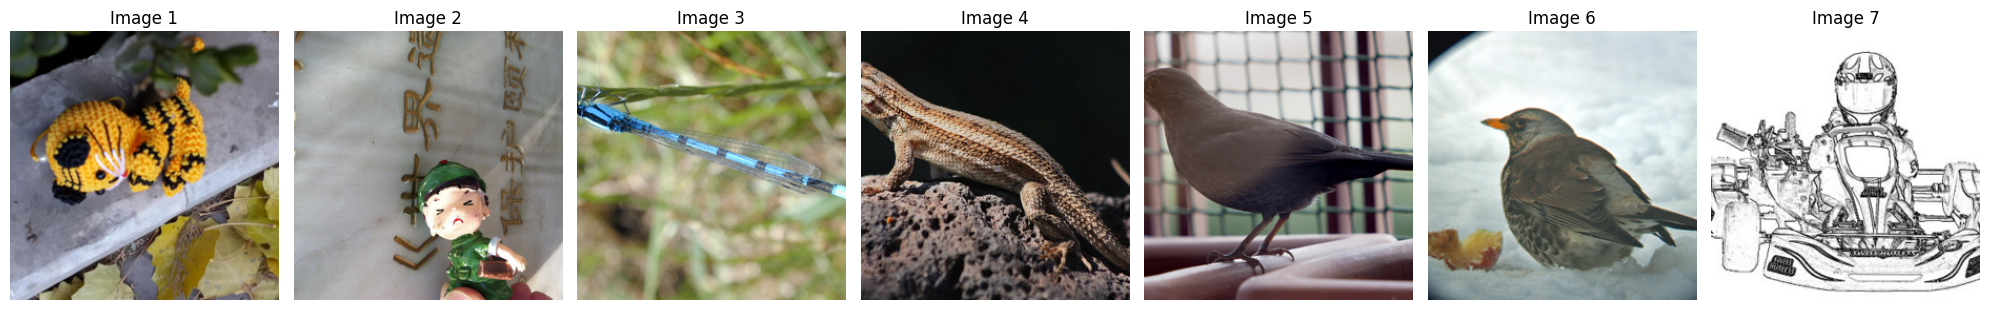

In [14]:
import matplotlib.pyplot as plt
from PIL import Image

# Пути к изображениям
image_files = [
    "/content/drive/MyDrive/Colab Notebooks/CV/dataset/dataset/3419.png",
    "/content/drive/MyDrive/Colab Notebooks/CV/dataset/dataset/2535.png",
    "/content/drive/MyDrive/Colab Notebooks/CV/dataset/dataset/0194.png",
    "/content/drive/MyDrive/Colab Notebooks/CV/dataset/dataset/2086.png",
    "/content/drive/MyDrive/Colab Notebooks/CV/dataset/dataset/4511.png",
    "/content/drive/MyDrive/Colab Notebooks/CV/dataset/dataset/5961.png",
    "/content/drive/MyDrive/Colab Notebooks/CV/dataset/dataset/7607.png"
]

# Создаем подкатегорию для отображения изображений
fig, axes = plt.subplots(1, 7, figsize=(20, 5))

# Загружаем и отображаем изображения
for i, image_path in enumerate(image_files):
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].axis('off')  # Убираем оси
    axes[i].set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()


In [5]:
from PIL import Image
import numpy as np
import os
from tqdm import tqdm
import torch
from transformers import CLIPProcessor, CLIPModel

# Загружаем модель и процессор CLIP
model_name = "openai/clip-vit-base-patch16"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

# Путь к папке с изображениями
image_folder = '/content/drive/MyDrive/Colab Notebooks/CV/dataset/dataset'
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

# Словарь для хранения признаков изображений
features_dict = {}

# Функция для извлечения признаков из изображения
def extract_features(image_path):
    image = Image.open(image_path).convert('RGB')
    inputs = processor(images=image, return_tensors="pt", padding=True)
    with torch.no_grad():
        features = model.get_image_features(**inputs)
    return features.numpy().flatten()  # Преобразуем признаки в одномерный массив

# Используем tqdm для отображения прогресса
for image_file in tqdm(image_files, desc="Извлечение признаков"):
    image_path = os.path.join(image_folder, image_file)
    features = extract_features(image_path)
    if features is not None:
        features_dict[image_file] = features

# Преобразуем все признаки в массив для расчета сходства
if features_dict:
    all_features = np.array(list(features_dict.values()))
    print(f"Размер массива признаков: {all_features.shape}")
else:
    print("Ошибка: не удалось извлечь признаки из изображений.")


config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Извлечение признаков:   3%|▎         | 330/9605 [05:01<2:21:01,  1.10it/s]


KeyboardInterrupt: 

In [8]:
!pip install torch torchvision Pillow
!pip install dinov2


In [1]:
import torch
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision import transforms

# Проверка GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Используется устройство: {device}")

# Загрузка модели DINOv2
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)
model.eval()  # Режим инференса

# Преобразования для изображений
transform = transforms.Compose([
    transforms.Resize(224),  # Убедимся, что размер 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Путь к папке с изображениями
image_folder = '/content/drive/MyDrive/Colab Notebooks/CV/dataset/dataset'
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
print(f"Найдено {len(image_files)} изображений")

# Словарь для хранения признаков
features_dict = {}

# Обработка каждого изображения по отдельности
for file_name in tqdm(image_files, desc="Извлечение признаков"):

        # Загрузка изображения
        img_path = os.path.join(image_folder, file_name)
        img = Image.open(img_path).convert('RGB')

        # Применение трансформаций
        img_tensor = transform(img).unsqueeze(0).to(device)  # Добавляем размерность батча

        # Извлечение признаков
        with torch.no_grad():
            features = model(img_tensor)

        # Сохранение результатов
        features_dict[file_name] = features.cpu().numpy().flatten()  # (384,)



# Проверка результатов
if features_dict:
    print(f"\nУспешно обработано: {len(features_dict)} изображений")
    print(f"Размерность признаков: {features_dict[next(iter(features_dict))].shape}")  # (384,)

    # Пример сохранения результатов
    np.savez("features.npz", **features_dict)
    print("Признаки сохранены в features.npz")
else:
    print("Не удалось обработать ни одного изображения")

Используется устройство: cpu


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
    PyTorch 2.3.1+cu121 with CUDA 1201 (you have 2.7.0+cu126)
    Python  3.11.9 (you have 3.11.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
/usr/local/lib/python3.11/dist-packages/xformers/ops/swiglu_op.py:127: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd
/usr/local/lib/python3.11/dist-packages/xformers/ops/swiglu_op.py:148: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_bwd
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
 

Найдено 9605 изображений


Извлечение признаков:   0%|          | 0/9605 [00:00<?, ?it/s]


NotImplementedError: No operator found for `memory_efficient_attention_forward` with inputs:
     query       : shape=(1, 257, 6, 64) (torch.float32)
     key         : shape=(1, 257, 6, 64) (torch.float32)
     value       : shape=(1, 257, 6, 64) (torch.float32)
     attn_bias   : <class 'NoneType'>
     p           : 0.0
`decoderF` is not supported because:
    device=cpu (supported: {'cuda'})
    attn_bias type is <class 'NoneType'>
    operator wasn't built - see `python -m xformers.info` for more info
`flshattF@0.0.0` is not supported because:
    device=cpu (supported: {'cuda'})
    dtype=torch.float32 (supported: {torch.float16, torch.bfloat16})
    operator wasn't built - see `python -m xformers.info` for more info
`cutlassF` is not supported because:
    device=cpu (supported: {'cuda'})
    operator wasn't built - see `python -m xformers.info` for more info
`smallkF` is not supported because:
    max(query.shape[-1] != value.shape[-1]) > 32
    device=cpu (supported: {'cuda'})
    operator wasn't built - see `python -m xformers.info` for more info
    unsupported embed per head: 64

In [18]:
!pip uninstall -y numpy pillow torch torchvision
!pip install --upgrade --force-reinstall numpy pillow torch torchvision

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: pillow 11.2.1
Uninstalling pillow-11.2.1:
  Successfully uninstalled pillow-11.2.1
Found existing installation: torch 2.0.1
Uninstalling torch-2.0.1:
  Successfully uninstalled torch-2.0.1
Found existing installation: torchvision 0.15.2
Uninstalling torchvision-0.15.2:
  Successfully uninstalled torchvision-0.15.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.8 MB/s eta 0:00:00
  Using cached setuptools-80.0.0-py3-none-any.whl.metadata (6.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 51.3 MB/s eta 0:00:00
   ━━━━━

In [1]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
from torchvision import transforms

# Принудительно отключаем xformers и другие GPU-оптимизации
torch.backends.cuda.enable_flash_sdp(False)
torch.backends.cuda.enable_mem_efficient_sdp(False)

# Проверка и установка зависимостей
try:
    import numpy as np
except ImportError:
    !pip install numpy pillow torch torchvision
    import numpy as np

# Убедимся, что используем CPU
device = torch.device("cpu")
print("Используется устройство: CPU")

# Загрузка модели с отключенными GPU-зависимостями
try:
    model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14', pretrained=True, force_reload=True)
    model = model.to(device).eval()
    # Отключаем attention оптимизации для CPU
    for module in model.modules():
        if hasattr(module, 'attention'):
            module.attention = lambda x: x  # Заменяем attention на пустую операцию
except Exception as e:
    print(f"Ошибка загрузки модели: {e}")
    raise

# Упрощенные трансформации для CPU
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def process_image(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            features = model(img_tensor)
        return features.cpu().numpy().flatten()
    except Exception as e:
        print(f"Ошибка обработки {image_path}: {e}")
        return None

# Обработка всех изображений
image_folder = '/content/drive/MyDrive/Colab Notebooks/CV/dataset/dataset'
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
features_dict = {}

for file_name in tqdm(image_files, desc="Извлечение признаков"):
    img_path = os.path.join(image_folder, file_name)
    features = process_image(img_path)
    if features is not None:
        features_dict[file_name] = features

# Сохранение результатов
if features_dict:
    np.savez("features_cpu.npz", **features_dict)
    print(f"Успешно обработано {len(features_dict)} изображений")
else:
    print("Не удалось обработать ни одного изображения")

Используется устройство: CPU


Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 295MB/s]
Извлечение признаков:   0%|          | 34/9605 [00:32<2:30:52,  1.06it/s]


KeyboardInterrupt: 

In [2]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
from torchvision import transforms

# Проверка и установка зависимостей
try:
    import numpy as np
    from PIL import Image
except ImportError:
    !pip install numpy pillow torch torchvision
    import numpy as np
    from PIL import Image

# Проверка доступности GPU и выделение памяти
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print(f"Используется GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.empty_cache()
    # Настройка для максимальной производительности на T4
    torch.backends.cuda.enable_flash_sdp(True)
    torch.backends.cuda.enable_mem_efficient_sdp(True)
else:
    print("Используется CPU - рекомендуется активировать GPU в Colab!")
    device = torch.device("cpu")

# Загрузка модели с оптимизациями для GPU
try:
    model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14', pretrained=True)
    model = model.to(device).eval()
    print("Модель успешно загружена на GPU")
except Exception as e:
    print(f"Ошибка загрузки модели: {e}")
    raise

# Оптимизированные трансформации для GPU
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Функция для батчевой обработки на GPU
def process_batch(image_paths, batch_size=32):
    images = []
    valid_paths = []

    for path in image_paths:
        try:
            img = Image.open(path).convert('RGB')
            img = transform(img)
            images.append(img)
            valid_paths.append(path)
        except Exception as e:
            print(f"Ошибка загрузки {path}: {e}")

    if not images:
        return None, []

    # Создаем батч и переносим на GPU
    batch = torch.stack(images).to(device)

    with torch.no_grad():
        features = model(batch)

    return features.cpu().numpy(), valid_paths

# Основной процесс обработки
image_folder = '/content/drive/MyDrive/Colab Notebooks/CV/dataset/dataset'
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
features_dict = {}
batch_size = 64  # Можно увеличить до 128 если хватает памяти

print(f"Найдено {len(image_files)} изображений. Начинаем обработку...")

# Обработка батчами с прогресс-баром
for i in tqdm(range(0, len(image_files), batch_size), desc="Обработка на GPU"):
    batch_files = image_files[i:i + batch_size]
    batch_paths = [os.path.join(image_folder, f) for f in batch_files]

    batch_features, valid_paths = process_batch(batch_paths, batch_size)

    if batch_features is not None:
        for j, path in enumerate(valid_paths):
            file_name = os.path.basename(path)
            features_dict[file_name] = batch_features[j].flatten()

    # Очистка памяти GPU после каждого батча
    torch.cuda.empty_cache()

# Сохранение результатов
if features_dict:
    output_file = "dino_features_gpu.npz"
    np.savez(output_file, **features_dict)
    print(f"\nРезультаты:")
    print(f"Успешно обработано: {len(features_dict)} изображений")
    print(f"Сохранено в: {output_file}")

    # Пример загрузки результатов:
    # with np.load(output_file) as data:
    #     features = {k: data[k] for k in data.files}
else:
    print("Не удалось обработать ни одного изображения")

Используется GPU: Tesla T4


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Модель успешно загружена на GPU
Найдено 9605 изображений. Начинаем обработку...


Обработка на GPU: 100%|██████████| 151/151 [06:00<00:00,  2.39s/it]



Результаты:
Успешно обработано: 9605 изображений
Сохранено в: dino_features_gpu.npz


In [3]:
features_dict

{'3419.png': array([ 1.3847332e-01, -1.8476751e+00, -8.4568001e-02, -8.2941765e-01,
         8.9282811e-01, -5.1616794e-01, -2.5019956e+00, -8.3846998e-01,
         6.3809419e-01, -2.6704321e+00, -4.8055429e-02, -2.0128784e+00,
         2.2189617e+00, -2.4225264e+00,  1.5278170e+00, -7.4323875e-01,
         4.3817840e+00,  3.0070815e+00, -7.0523024e-02, -1.9482998e+00,
        -2.0745611e+00, -1.5312615e-01, -1.4934199e+00,  1.3072426e+00,
         9.2288464e-01,  3.8458610e+00, -1.5028532e+00,  5.1705265e-01,
        -1.1156656e+00,  3.9930768e+00,  7.8940135e-01, -1.4845865e+00,
         1.5727566e+00,  5.3286295e+00, -1.9653351e+00,  1.1976217e+00,
         7.3320216e-01,  2.7359929e+00, -2.7044907e+00,  1.3504498e+00,
         1.0488857e+00,  1.1441517e+00,  1.9319266e+00, -7.3494217e-03,
         2.5193887e+00, -1.5460092e-01, -3.1253153e-01, -1.2304369e-01,
         1.6621685e-01, -1.3474627e+00, -1.3218983e+00,  2.1329954e+00,
        -1.2150629e+00, -3.8118606e+00,  6.2841052e-

In [4]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from tqdm import tqdm

# Подготовка данных для быстрого расчета
print("Подготовка данных для расчета схожести...")
all_filenames = list(features_dict.keys())
all_features = np.array([features_dict[name] for name in all_filenames])

# Оптимизированная функция для расчета схожести с обработкой на GPU
def get_similar_images(query_features, all_features, filenames, top_k=6):
    """
    Возвращает top_k наиболее похожих изображений (исключая само изображение)
    """
    # Расчет косинусного сходства на GPU (если доступно)
    if torch.cuda.is_available():
        query_tensor = torch.tensor(query_features, device=device).float()
        features_tensor = torch.tensor(all_features, device=device).float()
        similarities = torch.nn.functional.cosine_similarity(
            query_tensor.unsqueeze(0),
            features_tensor,
            dim=1
        )
        similarities = similarities.cpu().numpy()
    else:
        similarities = cosine_similarity(
            query_features.reshape(1, -1),
            all_features
        )[0]

    # Получаем индексы наиболее похожих изображений (исключая само изображение)
    most_similar = np.argpartition(-similarities, range(1, top_k+1))[1:top_k+1]
    return [filenames[i] for i in most_similar]

# Создаем рекомендации с прогресс-баром
print("\nСоздание рекомендаций...")
recommendations = {}
for filename, features in tqdm(features_dict.items(), desc="Обработка изображений"):
    similar_images = get_similar_images(features, all_features, all_filenames, top_k=6)
    recommendations[filename] = ' '.join(similar_images)

# Создаем и сохраняем DataFrame
print("\nСохранение результатов...")
recommendations_df = pd.DataFrame({
    'filename': list(recommendations.keys()),
    'ranking': list(recommendations.values())
})

output_path = '/content/drive/MyDrive/Colab Notebooks/CV/recommendations.csv'
recommendations_df.to_csv(output_path, index=False)

print(f"\nГотово! Результаты сохранены в: {output_path}")
print(f"Всего обработано: {len(recommendations)} изображений")
print("Пример рекомендаций:")
print(recommendations_df.head())

Подготовка данных для расчета схожести...

Создание рекомендаций...


Обработка изображений: 100%|██████████| 9605/9605 [00:39<00:00, 243.94it/s]



Сохранение результатов...

Готово! Результаты сохранены в: /content/drive/MyDrive/Colab Notebooks/CV/recommendations.csv
Всего обработано: 9605 изображений
Пример рекомендаций:
   filename                                            ranking
0  3419.png  4796.png 6140.png 2738.png 5057.png 1161.png 9...
1  2086.png  2276.png 1639.png 7383.png 8778.png 2780.png 4...
2  2535.png  3122.png 4344.png 9301.png 4725.png 1553.png 5...
3  4511.png  1513.png 9405.png 3361.png 5170.png 7085.png 5...
4  0194.png  8185.png 9336.png 4309.png 1313.png 3616.png 8...


In [5]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def evaluate_recommendations(features_dict, recommendations_df, n_neighbors=6):
    # Подготовка данных
    filenames = list(features_dict.keys())
    features = np.array([features_dict[name] for name in filenames])

    # Истинные соседи (по признакам)
    nbrs = NearestNeighbors(n_neighbors=n_neighbors+1, metric='cosine').fit(features)
    _, true_indices = nbrs.kneighbors(features)

    # Преобразование рекомендаций в индексы
    rec_indices = []
    for filename in filenames:
        recs = recommendations_df[recommendations_df['filename'] == filename]['ranking'].values[0].split()
        rec_indices.append([filenames.index(r) for r in recs])

    # Расчет precision@k
    precision_scores = []
    for i in range(len(filenames)):
        true = set(true_indices[i][1:])  # Исключаем сам элемент
        pred = set(rec_indices[i][:n_neighbors])
        precision_scores.append(len(true & pred) / n_neighbors)

    mean_precision = np.mean(precision_scores)
    print(f"Mean Precision@{n_neighbors}: {mean_precision:.4f}")

    # Дополнительные метрики
    coverage = len(set([r for recs in rec_indices for r in recs])) / len(filenames)
    print(f"Coverage: {coverage:.4f} (уникальные рекомендации)")

# Пример использования
evaluate_recommendations(features_dict, recommendations_df)

Mean Precision@6: 0.9988
Coverage: 0.9573 (уникальные рекомендации)
